In [1]:
import numpy as np
from cv2.aruco import Dictionary_create, DetectorParameters, CORNER_REFINE_SUBPIX, detectMarkers
from cv2 import aruco, cvtColor, COLOR_BGR2GRAY, LUT, imread
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from funktionen import *
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import inv as sparse_inv
from scipy.optimize import least_squares
from scipy import stats
import piexif

In [2]:
dateien = []
# [dateien.append(i) for i in glob("../../bilderserien/wuerfel/*.jpg")]
[dateien.append(i) for i in glob("../../bilderserien/wuerfel7/*.jpg")]
[dateien.append(i) for i in glob("../../bilderserien/wuerfel8/*.jpg")]
[dateien.append(i) for i in glob("../../bilderserien/wuerfel9/*.jpg")]
# [dateien.append(i) for i in glob("../../bilderserien/wuerfel10/*.jpg")]
pictures = pd.DataFrame([[i, int(pfad[-6:-4])-1, pfad, None, None, None, None, None, None] for i, pfad in enumerate(dateien)], columns=["img", "kamera",
                        "pfad", "t1", "t2", "t3", "r1", "r2", "r3"]).astype({"kamera": int, "pfad": str, "img": int, "t1": float, "t2": float, "t3": float, "r1": float, "r2": float, "r3": float}).set_index(["img"])
# np.c_[t.T,rod.T]

In [3]:
pictures_bekannt = pd.read_csv("wuerfel_pictures_neu.csv").astype({"kamera": int, "pfad": str, "img": int, "t1": float,
                                                                   "t2": float, "t3": float, "r1": float, "r2": float, "r3": float}).set_index(["img"])
pictures.update(pictures_bekannt)
pictures

,kamera,pfad,t1,t2,t3,r1,r2,r3
img,,,,,,,,
0,0,../../bilderserien/wuerfel7/camera01.jpg,3.211019,9.561403,66.674753,2.324562,-0.965364,0.297921
1,1,../../bilderserien/wuerfel7/camera02.jpg,1.545604,23.715545,48.083039,1.886703,-0.799237,0.497872
2,2,../../bilderserien/wuerfel7/camera03.jpg,1.605645,4.808200,34.236332,1.668996,-0.704728,0.582925
3,3,../../bilderserien/wuerfel7/camera04.jpg,1.076796,14.443963,76.547854,2.523409,-0.018481,0.000617
4,4,../../bilderserien/wuerfel7/camera05.jpg,1.112453,18.485234,47.784357,2.077440,-0.009277,0.004993
...,...,...,...,...,...,...,...,...
67,19,../../bilderserien/wuerfel9/camera20.jpg,NaN,NaN,NaN,NaN,NaN,NaN
68,20,../../bilderserien/wuerfel9/camera21.jpg,NaN,NaN,NaN,NaN,NaN,NaN
69,21,../../bilderserien/wuerfel9/camera22.jpg,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dist = []
for i, pic in pictures.iterrows():
    try:
        d = piexif.load(pic["pfad"])["Exif"][piexif.ExifIFD.SubjectDistance]
        dist.append(d[0]/d[1]*1000)
    except:
        dist.append(np.nan)
pictures["dist"] = dist

In [5]:
pictures

,kamera,pfad,t1,t2,t3,r1,r2,r3,dist
img,,,,,,,,,
0,0,../../bilderserien/wuerfel7/camera01.jpg,3.211019,9.561403,66.674753,2.324562,-0.965364,0.297921,2350.0
1,1,../../bilderserien/wuerfel7/camera02.jpg,1.545604,23.715545,48.083039,1.886703,-0.799237,0.497872,890.0
2,2,../../bilderserien/wuerfel7/camera03.jpg,1.605645,4.808200,34.236332,1.668996,-0.704728,0.582925,450.0
3,3,../../bilderserien/wuerfel7/camera04.jpg,1.076796,14.443963,76.547854,2.523409,-0.018481,0.000617,3160.0
4,4,../../bilderserien/wuerfel7/camera05.jpg,1.112453,18.485234,47.784357,2.077440,-0.009277,0.004993,730.0
...,...,...,...,...,...,...,...,...,...
67,19,../../bilderserien/wuerfel9/camera20.jpg,NaN,NaN,NaN,NaN,NaN,NaN,950.0
68,20,../../bilderserien/wuerfel9/camera21.jpg,NaN,NaN,NaN,NaN,NaN,NaN,580.0
69,21,../../bilderserien/wuerfel9/camera22.jpg,NaN,NaN,NaN,NaN,NaN,NaN,1200.0


In [6]:

aruco_dict = Dictionary_create(32, 3)
parameter = DetectorParameters.create()
parameter.cornerRefinementMethod = CORNER_REFINE_SUBPIX
LUT_IN = [0, 158, 216, 255]
LUT_OUT = [0, 22, 80, 176]
lut = np.interp(np.arange(0, 256),
                LUT_IN, LUT_OUT).astype(np.uint8)

In [7]:
cornersList = []
for j, img in pictures.iterrows():
    imgCV = cv2.imread(img['pfad'])
    gray = cvtColor(imgCV, COLOR_BGR2GRAY)
    tmp_corners, tmp_ids, t = detectMarkers(
        gray, aruco_dict, parameters=parameter)
    for c, i in zip(tmp_corners, tmp_ids):
        size = np.linalg.norm(c[0][0] - c[0][1])
        # print(size)
        if size < 100:
            continue
        for k in range(len(c[0])):
            add = 0
            if int(str(j)) >= 48 and i[0] >= 24:
                add = 100
            cornersList.append([j, i[0]+add, k, c[0][k][0], c[0][k][1]])
corners = pd.DataFrame(cornersList, columns=[
                       "img", "marker", "ecke", "x", "y"])
corners.set_index(["img", "marker", "ecke"], inplace=True)

In [8]:
corners.reset_index()["marker"].unique()

array([ 25,  14,  24,  15,  13,   7,   3,  10,  31,  30,   2,   9,  22,
        12,   8,  18,  28,   4,   5,  11,   0,  17,  23,  27,   1,   6,
        19,  21,  16,  20, 131, 128, 125, 130, 124, 127])

In [9]:
ca = corners.reset_index().set_index(["marker", "ecke"])
matched = ca.join(ca, lsuffix="_a", rsuffix="_b").query(
    'img_a < img_b')
matched.reset_index(inplace=True)
matched

,marker,ecke,img_a,x_a,y_a,img_b,x_b,y_b
0,0,0,10,1120.094238,1203.935669,14,2544.799072,306.507965
1,0,0,10,1120.094238,1203.935669,16,4407.567871,624.541260
2,0,0,10,1120.094238,1203.935669,17,4170.730957,593.552734
3,0,0,10,1120.094238,1203.935669,33,1213.804077,839.303955
4,0,0,10,1120.094238,1203.935669,34,1110.479858,1726.738403
...,...,...,...,...,...,...,...,...
17339,130,3,66,2282.674561,1689.280762,68,2263.587646,1553.924316
17340,131,0,50,2338.161865,2133.745361,66,2439.387451,1950.931641
17341,131,1,50,2061.794678,2019.125610,66,2301.039551,2072.828125
17342,131,2,50,2056.745361,1636.691162,66,2304.489746,1987.936523


In [10]:
coords_wuerfel = pd.read_csv(
    "../../arucoWuerfel.csv").astype({'x': float, 'y': float, 'z': float})
coords_wuerfel.set_index(["marker", "ecke"], inplace=True)
coords = pd.read_csv(
    "./wuerfel_coords_neu.csv").astype({'x': float, 'y': float, 'z': float})
coords.set_index(["marker", "ecke"], inplace=True)
# coords = coords_wuerfel.copy()
coords

x          y          z
marker ecke                                 
26     0      2.119680  -2.892866   4.861267
       1      2.174389  -2.835364   1.027206
       2     -1.767211  -2.855080   1.087953
       3     -1.836378  -2.966859   4.808151
28     0      3.214653  -1.785665   4.703925
...                ...        ...        ...
23     3    -22.297375  30.047210  50.654454
20     0     20.900035 -29.319210  44.277707
       1     23.282604 -26.992440  44.263108
       2     22.998284 -26.681057  47.587874
       3     20.635294 -29.024330  47.600225

[128 rows x 3 columns]

In [11]:
kameras = pd.DataFrame([[i, 0, 0., 0., 0.] for i in pictures["kamera"].unique(
)], columns=["kamera", "typ", "df", "dcx", "dcy"]).set_index(["kamera"])
kameras

,typ,df,dcx,dcy
kamera,,,,
0,0,0.0,0.0,0.0
1,0,0.0,0.0,0.0
2,0,0.0,0.0,0.0
3,0,0.0,0.0,0.0
4,0,0.0,0.0,0.0
5,0,0.0,0.0,0.0
6,0,0.0,0.0,0.0
7,0,0.0,0.0,0.0
8,0,0.0,0.0,0.0


In [12]:
typen = pd.read_csv("./wuerfel_typen.csv")
typen.set_index(["typ"], inplace=True)
typen["fx"] = (typen["fx"]+typen["fy"])*0.5
typen.rename(columns={"fx": "f"}, inplace=True)
typen.drop(columns=["fy"], inplace=True)
typen

,f,cx,cy,d1,d2,d3,d4,d5
typ,,,,,,,,
0,3432.68447,2290.739672,1259.733123,0.099693,-0.259201,-0.001514,-0.002651,0.202808


In [13]:
def get_kamera(kameras, kid):
    kamera = kameras.iloc[kid]
    typ = typen.loc[kamera["typ"]]
    mtx = np.array([[kamera["df"] + typ["f"], 0, kamera["dcx"] + typ["cx"]],
                    [0, kamera["df"] + typ["f"], kamera["dcy"] + typ["cy"]],
                    [0, 0, 1]])
    dist = np.array(typ[["d1", "d2", "d3", "d4", "d5"]])
    return mtx, dist

In [14]:
def neues_bild(coords, pictures, kameras, corners):
    lp = corners.join(coords, lsuffix="_img", rsuffix="").dropna().join(
        pictures, lsuffix="", rsuffix="_cam")
    lp = lp[lp["r1"].isnull()]
    bild = lp.groupby("img").count().sort_values(
        "x_img", ascending=False).first_valid_index()
    passpunkte = lp.query('img == ' + str(bild)).reset_index()
    pp = passpunkte[['x_img', 'y_img', 'x', 'y', 'z']].values
    if bild is None:
        print("nichts gefunden")
        return pictures
    kid = pictures.query('img == ' + str(bild))['kamera'].values[0]
    k, dist = get_kamera(kameras, kid)

    if len(pp) >= 4:
        _, r, t, _ = cv2.solvePnPRansac(pp[:, 2:], pp[:, :2], k, dist)
        rod, _ = cv2.Rodrigues(r)
        pictures.loc[bild, ["t1", "t2", "t3", "r1", "r2", "r3"]] = [
            t[0][0], t[1][0], t[2][0], r[0][0], r[1][0], r[2][0]]
    return pictures

In [15]:
for i in range(80):
    if len(pictures.query('t1.isnull()')) == 0:
        break
    pictures = neues_bild(coords, pictures, kameras, corners)

In [33]:
pictures.iloc[62][[]] = [-0.000000, 0.000000,
                         0.000000, 0.000000, 0.000000, 0.000000]

ValueError: Must have equal len keys and value when setting with an iterable

In [16]:
def wolke_zeigen(coords, pictures):

    # pip install plotly

    import plotly.graph_objs as go

    coords_img = []
    for _, p in pictures.dropna().iterrows():
        rt = p[['r1', 'r2', 'r3']].to_numpy(dtype=np.float64)
        R = cv2.Rodrigues(rt)[0]
        R = np.linalg.inv(R)
        t = p[['t1', 't2', 't3']].to_numpy(dtype=np.float64).T
        t = -R@t
        coords_img.append(t)
    coords_img = np.array(coords_img)

    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(x=coords['x'], y=coords['y'], z=coords['z'], mode='markers', name='Original Points'),
                          go.Scatter3d(x=coords_img[:, 0], y=coords_img[:, 1], z=coords_img[:, 2],
                                       mode='markers', name='Kameras')])

    # Add labels to the plot
    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                      title='Rotation and Translation Vectors in 3D')
    fig.layout.scene.camera.projection.type = "orthographic"
    fig.show()


wolke_zeigen(coords, pictures)

In [18]:
def neue_koordinaten(coords, pictures, kameras):
    pic_a = pictures.reset_index().rename(
        columns={"img": "img_a"}).set_index("img_a")
    pic_b = pictures.reset_index().rename(
        columns={"img": "img_b"}).set_index("img_b")
    matched = ca.add_suffix('_a').join(ca.add_suffix('_b')).query(
        'img_a < img_b').join(coords.add_suffix("_ca"))
    # print(matched)
    matched = matched[matched["x_ca"].isnull()].reset_index().set_index([
        "img_a", "img_b"])
    matched = matched.join(pic_a.add_suffix("_a"))
    matched = matched.join(pic_b.add_suffix("_b"))
    # print(matched)
    matched.dropna(subset=['t1_a', 't1_b'], inplace=True)
    matched = matched.reset_index().set_index(["marker", "ecke"])

    beste = matched.groupby(["marker"]).count().sort_values(
        "img_a", ascending=False)
    beste

    # print(beste)

    for bester in beste.reset_index().values[:, 0]:
        new = []
        # print(bester)
        for i in range(4):
            cneu = []

            for i, v in matched.query("marker =="+str(bester)).query("ecke =="+str(i)).iterrows():
                # print(v)
                K1, dist1 = get_kamera(kameras, v['kamera_a'])
                K2, dist2 = get_kamera(kameras, v['kamera_b'])
                R1 = cv2.Rodrigues(
                    np.array(list(v[['r1_a', 'r2_a', 'r3_a']].to_numpy(dtype=np.float64))))[0]
                R2 = cv2.Rodrigues(
                    np.array(list(v[['r1_b', 'r2_b', 'r3_b']].to_numpy(dtype=np.float64))))[0]
                t1 = v[['t1_a', 't2_a', 't3_a']].to_numpy(dtype=np.float64)
                t2 = v[['t1_b', 't2_b', 't3_b']].to_numpy(dtype=np.float64)
                P1 = np.c_[R1, t1]
                P2 = np.c_[R2, t2]
                pt1 = np.array(list(v[['x_a', 'y_a']]))
                pt2 = np.array(list(v[['x_b', 'y_b']]))
                p1n = cart2hom(cv2.undistortPoints(pt1, K1, dist1)[0][0])
                p2n = cart2hom(cv2.undistortPoints(pt2, K2, dist2)[0][0])

                xy = reconstruct_one_point(p1n, p2n, P1, P2)
                xy /= xy[3]
                cneu.append(xy[0:3])

            if len(cneu) == 0:
                continue
            data = pd.DataFrame(cneu, columns=["x", "y", "z"])
            # print('before',data[["x", "y", "z"]].std())
            zscore = np.abs(stats.zscore(data[["x", "y", "z"]]))
            # print(zscore)
            zscore.fillna(0, inplace=True)
            # Identify outliers as students with a z-score greater than 3
            threshold = 3
            data = data[zscore <= threshold].dropna()
            # print('after',data[["x", "y", "z"]].std())
            if data['x'].std() > 2 or data['y'].std() > 2 or data['z'].std() > 2:
                # print(data)
                continue
            # print(data[(np.abs(stats.zscore(data)) < 2).all(axis=1)])
            median = data.mean().values
            new.append([bester, i[1], median[0], median[1], median[2]])
        # print(new)
        if len(new) == 4:
            new = pd.DataFrame(new, columns=["marker", "ecke", "x", "y", "z"]).set_index(
                ["marker", "ecke"])
            coords = pd.concat([coords, new])
            return True, coords
    return False, coords


neue_koordinaten(coords, pictures, kameras)

(True,
                      x          y          z
 marker ecke                                 
 26     0      2.119680  -2.892866   4.861267
        1      2.174389  -2.835364   1.027206
        2     -1.767211  -2.855080   1.087953
        3     -1.836378  -2.966859   4.808151
 28     0      3.214653  -1.785665   4.703925
 ...                ...        ...        ...
 20     3     20.635294 -29.024330  47.600225
 128    0      3.165198  -1.364808   4.686849
        1      3.224502   2.435898   4.682423
        2      3.160531   2.305596   0.799378
        3      3.059845  -1.504784   0.780046
 
 [132 rows x 3 columns])

In [19]:
treffer, coords = neue_koordinaten(coords, pictures, kameras)
treffer

True

### Ausgleichung

In [20]:
def passpunkt_groesse(coords):
    l = []
    l_beschriftung = []
    A = []
    m = 3.4
    for marker in coords.reset_index()['marker'].unique():
        # print(marker)
        if (marker >= 24 and marker <= 25) or (marker >= 124 and marker <= 125):
            m = 7.2
        elif (marker >= 26 and marker < 99) or (marker >= 126 and marker < 199):
            m = 4.0
        else:
            m = 3.4
        m1 = np.where(coords.index == (marker, 0))[0][0]
        m2 = np.where(coords.index == (marker, 1))[0][0]
        m3 = np.where(coords.index == (marker, 2))[0][0]
        m4 = np.where(coords.index == (marker, 3))[0][0]
        l_beschriftung.append("m" + str(marker) + "e1-2")
        l_beschriftung.append("m" + str(marker) + "e1-3")
        l_beschriftung.append("m" + str(marker) + "e1-4")
        l_beschriftung.append("m" + str(marker) + "e2-3")
        l_beschriftung.append("m" + str(marker) + "e2-4")
        l_beschriftung.append("m" + str(marker) + "e3-4")
        l.append(m)
        l.append(m*2**0.5)
        l.append(m)
        l.append(m)
        l.append(m*2**0.5)
        l.append(m)
        A.append([m1*2, m1*2 + 1, m2*2, m2*2+1])
        A.append([m1*2, m1*2 + 1, m3*2, m3*2+1])
        A.append([m1*2, m1*2 + 1, m4*2, m4*2+1])
        A.append([m2*2, m2*2 + 1, m3*2, m3*2+1])
        A.append([m2*2, m2*2 + 1, m4*2, m4*2+1])
        A.append([m3*2, m3*2 + 1, m4*2, m4*2+1])
    l = np.array(l)
    # print(l)
    A = np.array(A)
    return A, l, l_beschriftung

In [21]:
def bekannte_punkte(coords, bekannte):
    l = []
    l_beschriftung = []
    A = []
    for id, i in bekannte.reset_index().iterrows():
        l_beschriftung.append(str(i['marker']) + '-' + str(i['ecke'])+'x')
        l_beschriftung.append(str(i['marker']) + '-' + str(i['ecke'])+'y')
        l_beschriftung.append(str(i['marker']) + '-' + str(i['ecke'])+'z')
        l.append(i['x'])
        l.append(i['y'])
        l.append(i['z'])
        m1 = np.where(coords.index == (i['marker'], i['ecke']))[0][0]
        A.append([m1*3])
        A.append([m1*3 + 1])
        A.append([m1*3 + 2])
    l = np.array(l)
    A = np.array(A)
    return A, l.ravel(), l_beschriftung

In [22]:
def ausgleichung(coords, pictures, kameras, typen, corners, bekannte):
    lp = corners.join(coords, lsuffix="_img", rsuffix="").join(
        pictures, lsuffix="", rsuffix="_cam").dropna()

    Apg, lpg, lpg_beschriftung = passpunkt_groesse(coords)
    Abp, lbp, lbp_beschriftung = bekannte_punkte(coords, bekannte)

    typ = typen.reset_index().values
    typ_ids = np.array(typ[:, 0], dtype=np.int32)

    kamera = kameras.reset_index().values
    kamera_ids = np.array(kamera[:, :2], dtype=np.int32)

    bilder = pictures.reset_index().dropna().drop(
        'pfad', axis=1).to_numpy(dtype=np.float32)
    bilder_ids = np.array(bilder[:, :2], dtype=np.int32)

    passpunkte = coords.reset_index().values
    passpunkte_ids = np.array(passpunkte[:, :2], dtype=np.int32)

    messung = lp.reset_index().to_numpy()[:, :5]
    messung_ids = np.array(messung[:, :3], dtype=np.int32)

    l = np.hstack(
        (messung[:, -2:].astype(np.float32).ravel(), lpg.ravel(), lbp.ravel(), [0, 0, 0]), dtype=np.float32)

    l_beschriftung = np.hstack(
        ([str(i[0])+'-'+str(i[1])+'-'+str(i[2]) for i in messung_ids], lpg_beschriftung, lbp_beschriftung, ['df', 'dcx', 'dcy']))

    x0 = np.hstack((typ[:, 1:].ravel(),
                    kamera[:, 2:].ravel(),
                    bilder[:, 2:-1].ravel(),
                    passpunkte[:, 2:].ravel()), dtype=np.float32)

    A = lil_matrix((len(l), len(x0)), dtype=int)

    n_camera = len(kamera)
    n_typen = len(typen)
    n_bilder = len(bilder)
    n_passpunkte = len(passpunkte)
    n_messungen = len(messung)

    messung_bild_id = np.empty(n_messungen, dtype=np.int32)
    messung_kamera_id = np.empty(n_messungen, dtype=np.int32)
    messung_typ_id = np.empty(n_messungen, dtype=np.int32)
    messung_passpunkt_id = np.empty(n_messungen, dtype=np.int32)
    num_cam_param = 3
    num_typ_param = 8
    num_bild_param = 6
    num_pass_param = 3

    offset = n_typen * num_typ_param + n_camera * \
        num_cam_param + n_bilder * num_bild_param

    for i, a in enumerate(Apg):
        zeile = n_messungen + i
        for j in a:
            A[zeile, offset+j] = 1

    for i, a in enumerate(Apg):
        zeile = n_messungen + len(lpg) + i
        for j in a:
            A[zeile, offset+j] = 1

    for i, m in enumerate(messung):
        # print(m)
        bild_id, = np.where(bilder_ids[:, 0] == m[2])
        bild_id = bild_id[0]
        messung_bild_id[i] = bild_id

        camera_id_array,  = np.where(kamera_ids[:, 0] == bilder[bild_id, 1])
        camera_id = camera_id_array[0]
        messung_kamera_id[i] = camera_id

        type_id_array, = np.where(typ_ids[:] == kamera_ids[camera_id, 1])
        type_id = type_id_array[0]
        messung_typ_id[i] = type_id

        passpunkt_id_array, = np.where(
            (passpunkte_ids[:, 0] == m[0]) & (passpunkte_ids[:, 1] == m[1]))
        passpunkt_id = passpunkt_id_array[0]
        messung_passpunkt_id[i] = passpunkt_id

        # Typparameter
        offset = type_id*num_typ_param
        A[2*i:2*i+2, offset:offset+num_typ_param] = 1

        # Kameraparameter
        offset = n_typen*num_typ_param + camera_id*num_cam_param
        A[2*i:2*i+2, offset:offset+num_cam_param] = 1

        # Bildparameter
        offset = n_typen*num_typ_param + n_camera * \
            num_cam_param + bild_id * num_bild_param
        A[2*i:2*i+2, offset:offset + num_bild_param] = 1

        # Passpunktparameter
        offset = n_typen*num_typ_param + n_camera*num_cam_param + n_bilder * \
            num_bild_param + passpunkt_id * num_pass_param
        A[2*i:2*i+2, offset:offset + num_pass_param] = 1

    A[-3,  n_typen*num_typ_param+0: n_typen * num_typ_param +
        n_camera*num_cam_param:num_cam_param] = 1
    A[-2,  n_typen*num_typ_param+1: n_typen * num_typ_param +
        n_camera*num_cam_param:num_cam_param] = 1
    A[-1,  n_typen*num_typ_param+2: n_typen * num_typ_param +
        n_camera*num_cam_param:num_cam_param] = 1

    def project(x0: NDArray[np.float32]) -> NDArray[np.float32]:
        p = np.empty(len(l), dtype=np.float32)

        p[-3:] = 0

        dist = []
        for i in range(n_camera):
            typ = kamera_ids[i, 1]
            typ_offset = typ * num_typ_param
            cam_offset = n_typen*num_typ_param + i * num_cam_param
            p[-3] += x0[cam_offset]
            p[-2] += x0[cam_offset+1]
            p[-1] += x0[cam_offset+2]
            dist.append(np.array([x0[typ_offset + 3], x0[typ_offset + 4],
                                  x0[typ_offset + 5], x0[typ_offset + 6], x0[typ_offset + 7]]))

        # print(K)
        r = []
        t = []
        K = []
        for i, cam in bilder_ids:
            # for cam, typ in kamera_ids:
            typ = kamera_ids[cam, 1]
            typ_offset = typ * num_typ_param
            cam_offset = n_typen*num_typ_param + i * num_cam_param
            # sub_dist = bilder[i, -1]
            # if sub_dist != 0:
            #    sub_dist = 1./sub_dist/0.0014
            f = x0[typ_offset] + x0[cam_offset]  # + sub_dist
            cx = x0[cam_offset + 1]+x0[typ_offset + 1]
            cy = x0[cam_offset + 2]+x0[typ_offset + 2]
            K.append(np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]]))

            offset = n_typen*num_typ_param + n_camera * num_cam_param + \
                i * num_bild_param

            t.append(x0[offset:offset+3])
            r.append(x0[offset+3:offset+6])

        X = []
        for i, _ in enumerate(passpunkte_ids[:, 0]):
            # print(i)
            offset = n_typen*num_typ_param + n_camera * num_cam_param + \
                n_bilder*num_bild_param + \
                num_pass_param * i
            X.append(x0[offset:offset+3].reshape(1, 3))

        for i, m in enumerate(messung):
            punkt, _ = cv2.projectPoints(
                X[messung_passpunkt_id[i]], r[messung_bild_id[i]], t[messung_bild_id[i]], K[messung_bild_id[i]], dist[messung_kamera_id[i]])

            p[i*2] = punkt[0, 0, 0]
            p[i*2+1] = punkt[0, 0, 1]
            #  print(l[i*2:i*2+2], p[i*2:i*2+2])

        offset = n_messungen * 2
        for i, marker in enumerate(coords.reset_index()['marker'].unique()):
            # print(marker)
            if marker == 0:
                m = 15.6
            elif marker >= 24:
                m = 7.2
            else:
                m = 3.4
            m1 = np.where(coords.index == (marker, 0))[0][0]
            m2 = np.where(coords.index == (marker, 1))[0][0]
            m3 = np.where(coords.index == (marker, 2))[0][0]
            m4 = np.where(coords.index == (marker, 3))[0][0]

            p[offset+i +
                0] = np.linalg.norm(coords.values[m1] - coords.values[m2])
            p[offset+i +
                1] = np.linalg.norm(coords.values[m1] - coords.values[m3])
            p[offset+i +
                2] = np.linalg.norm(coords.values[m1] - coords.values[m4])
            p[offset+i +
                3] = np.linalg.norm(coords.values[m2] - coords.values[m3])
            p[offset+i +
                4] = np.linalg.norm(coords.values[m2] - coords.values[m4])
            p[offset+i +
                5] = np.linalg.norm(coords.values[m3] - coords.values[m4])
            # print(p[i:i+6])

        offset = n_messungen * 2 + len(lpg)
        for id, i in bekannte.reset_index().iterrows():
            pos = np.where(coords.index == (i['marker'], i['ecke']))[0][0]
            p[offset + 3*id] = x0[pos*3]
            p[offset + 3*id+1] = x0[pos*3+1]
            p[offset + 3*id+2] = x0[pos*3+2]
        #  print(p)
        # print(np.array(p.ravel()-l, dtype=np.float32))
        return np.array(l-p.ravel(), dtype=np.float32)
    # print(x0)
    # print(l)
    print(list(zip(l_beschriftung, project(x0))))
    res = least_squares(project, x0, jac_sparsity=A, verbose=2,
                        x_scale='jac', method='trf', xtol=1e-10)  # type: ignore

    x = res.x

    typen = pd.DataFrame(np.c_[typ_ids, x[:num_typ_param * n_typen].reshape(n_typen, num_typ_param)],
                         columns=["typ", "f", "cx", "cy", "d1", "d2", "d3", "d4", "d5"]).astype({"typ": int}).set_index("typ")

    kameras = pd.DataFrame(np.c_[kamera_ids, x[n_typen*num_typ_param:n_typen*num_typ_param + num_cam_param * n_camera].reshape(n_camera, num_cam_param)],
                           columns=["kamera", "typ", "df", "dcx", "dcy"]).astype({"kamera": int, "typ": int}).set_index("kamera")

    offset = n_typen*num_typ_param + num_cam_param * n_camera
    # print(bilder_ids[:, 1])
    neue_pictures = pd.DataFrame(np.c_[bilder_ids[:, 0], x[offset:offset+num_bild_param*n_bilder].reshape(
        n_bilder, num_bild_param), bilder[:, -1]], columns=["img", "x", "y", "z", "r1", "r2", "r3", "dist"]).astype({"img": int}).set_index("img")
    # print(neue_pictures)
    pictures.update(neue_pictures)

    offset = n_typen*num_typ_param + num_cam_param * \
        n_camera + num_bild_param*n_bilder
    coords = pd.DataFrame(np.c_[passpunkte_ids, x[offset:offset+num_pass_param*n_passpunkte].reshape(n_passpunkte, num_pass_param)],
                          columns=["marker", "ecke", "x", "y", "z"]).astype({"marker": int, "ecke": int}).set_index(["marker", "ecke"])

    # print(project(x).reshape(-1, 2))
    return res, kameras, typen, pictures, coords, l, x0, project(x0), l_beschriftung

In [23]:
vorher_coords = coords.copy()
vorher_pictures = pictures.copy()
vorher_kameras = kameras.copy()
vorher_typen = typen.copy()

In [71]:
coords = vorher_coords.copy()
pictures = vorher_pictures.copy()
kameras = vorher_kameras.copy()
typen = vorher_typen.copy()

In [25]:
# kameras, pictures, coords
res, kameras, typen, pictures, coords, l, x0, px0, l_beschriftung = ausgleichung(
    coords, pictures, kameras, typen, corners, coords_wuerfel)

[('0-0-10', -1.3710938), ('0-0-14', 0.114868164), ('0-0-16', -0.52563477), ('0-0-17', -0.46987915), ('0-0-33', -0.00390625), ('0-0-34', -1.4735107), ('0-0-36', -0.26660156), ('0-0-39', -0.8466797), ('0-0-57', 0.41174316), ('0-0-58', 1.8170776), ('0-0-64', -14.949463), ('0-1-10', -34.59851), ('0-1-14', -17.420898), ('0-1-16', -72.56384), ('0-1-17', -0.87060547), ('0-1-33', 0.37219238), ('0-1-34', 2.3114014), ('0-1-36', -1.0146484), ('0-1-39', -15.957153), ('0-1-57', -29.405579), ('0-1-58', -8.102539), ('0-1-64', -38.032288), ('0-2-10', -1.439209), ('0-2-14', 0.67871094), ('0-2-16', 0.93115234), ('0-2-17', -0.43893433), ('0-2-33', -2.2670898), ('0-2-34', -0.79901123), ('0-2-36', 0.30786133), ('0-2-39', -0.14996338), ('0-2-57', 0.69311523), ('0-2-58', 1.5440063), ('0-2-64', -15.6432495), ('0-3-10', -35.049683), ('0-3-14', -16.40747), ('0-3-16', -71.83441), ('0-3-17', -1.9399414), ('0-3-33', 0.2658081), ('0-3-34', 3.303711), ('0-3-36', -1.1097412), ('0-3-39', -16.997314), ('0-3-57', -29.80

/tmp/ipykernel_82214/3782255999.py:200: RuntimeWarning:

invalid value encountered in subtract



       1              3         3.4759e+08      7.02e+16       1.06e+01       1.49e+07    
       2              4         9.4723e+06      3.38e+08       8.49e+00       4.53e+06    
       3              5         9.3086e+06      1.64e+05       9.70e+00       2.07e+06    
       4              9         9.3079e+06      7.01e+02       4.49e-02       1.97e+06    
       5             10         9.3072e+06      6.84e+02       4.05e-02       1.87e+06    
       6             13         9.3071e+06      4.20e+01       2.37e-03       1.86e+06    
       7             14         9.3071e+06      4.20e+01       2.43e-03       1.85e+06    
       8             15         9.3070e+06      4.30e+01       2.43e-03       1.85e+06    


/tmp/ipykernel_82214/3782255999.py:200: RuntimeWarning:

invalid value encountered in subtract



       9             16         9.3070e+06      4.10e+01       2.47e-03       1.84e+06    


/tmp/ipykernel_82214/3782255999.py:200: RuntimeWarning:

invalid value encountered in subtract



      10             20         9.3070e+06      1.00e+00       3.91e-05       1.84e+06    
      11             21         9.3070e+06      2.00e+00       7.62e-05       1.84e+06    
      12             22         9.3070e+06      1.00e+00       1.54e-04       1.84e+06    
      13             27         9.3070e+06      0.00e+00       0.00e+00       1.84e+06    
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 7.0235e+16, final cost 9.3070e+06, first-order optimality 1.84e+06.


#### Kontrolle

In [26]:
wolke_zeigen(coords, pictures)

In [27]:
kameras.groupby("typ").mean()

,df,dcx,dcy
typ,,,
0,0.012534,0.099266,0.478657


In [28]:
kameras

,typ,df,dcx,dcy
kamera,,,,
0,0,-0.150888,1.303661,1.955153
1,0,0.264346,-0.146537,1.309287
2,0,-5.266179,-1.811040,-2.827298
3,0,-0.253898,-0.063533,1.412532
4,0,-3.823403,-0.071946,0.098482
5,0,-0.293680,-0.097926,-0.522267
6,0,-0.049502,-0.140381,1.760731
7,0,-0.296851,-0.129246,0.906435
8,0,1.165201,-0.199687,-0.095158


In [29]:
list(zip(l_beschriftung, px0.astype(np.int32)))

[('0-0-10', -1),
 ('0-0-14', 0),
 ('0-0-16', 0),
 ('0-0-17', 0),
 ('0-0-33', 0),
 ('0-0-34', -1),
 ('0-0-36', 0),
 ('0-0-39', 0),
 ('0-0-57', 0),
 ('0-0-58', 1),
 ('0-0-64', -14),
 ('0-1-10', -34),
 ('0-1-14', -17),
 ('0-1-16', -72),
 ('0-1-17', 0),
 ('0-1-33', 0),
 ('0-1-34', 2),
 ('0-1-36', -1),
 ('0-1-39', -15),
 ('0-1-57', -29),
 ('0-1-58', -8),
 ('0-1-64', -38),
 ('0-2-10', -1),
 ('0-2-14', 0),
 ('0-2-16', 0),
 ('0-2-17', 0),
 ('0-2-33', -2),
 ('0-2-34', 0),
 ('0-2-36', 0),
 ('0-2-39', 0),
 ('0-2-57', 0),
 ('0-2-58', 1),
 ('0-2-64', -15),
 ('0-3-10', -35),
 ('0-3-14', -16),
 ('0-3-16', -71),
 ('0-3-17', -1),
 ('0-3-33', 0),
 ('0-3-34', 3),
 ('0-3-36', -1),
 ('0-3-39', -16),
 ('0-3-57', -29),
 ('0-3-58', -11),
 ('0-3-64', -35),
 ('1-0-12', -1),
 ('1-0-13', 0),
 ('1-0-14', 1),
 ('1-0-16', 0),
 ('1-0-17', -1),
 ('1-0-18', -1),
 ('1-0-19', 0),
 ('1-0-20', -1),
 ('1-0-36', 1),
 ('1-0-37', 1),
 ('1-0-38', -15),
 ('1-0-39', -34),
 ('1-0-41', -16),
 ('1-0-42', -71),
 ('1-0-43', 0),
 ('1-0

In [30]:
picWC = pictures.copy()
picWC[['x', 'y', 'z']] = [-(cv2.Rodrigues(np.array(list(p[['r1', 'r2', 'r3']].values)))[
    0]).T @ p[['t1', 't2', 't3']].values.T for i, p in pictures.iterrows()]
picWC['d'] = np.linalg.norm(picWC[['x', 'y']].values, axis=1)
# pictures.loc[picWC['d'] > 35, ['t1', 't2', 't3', 'r1', 'r2', 'r3']] = np.nan
# pictures.loc[picWC['z'] < -5, ['t1', 't2', 't3', 'r1', 'r2', 'r3']] = np.nan

1
1


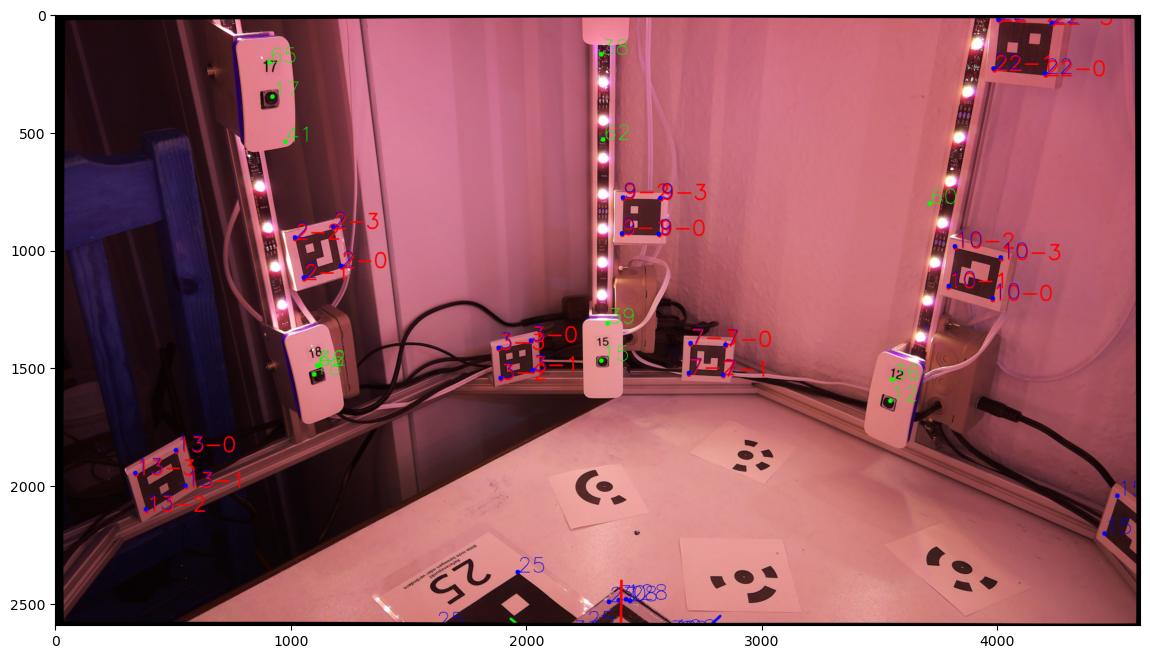

In [32]:
def zeige_auf_bildern(coords, pictures, kameras):
    picWC = pictures.dropna().copy()
    picWC[['x', 'y', 'z']] = [-(cv2.Rodrigues(np.array(list(p[['r1', 'r2', 'r3']].values)))[
                                0]).T @ p[['t1', 't2', 't3']].values.T for i, p in pictures.dropna().iterrows()]

    for nr in [1]:
        print(nr)
        imgCV = imread(pictures.query("img == "+str(nr))['pfad'].values[0])

        r = pictures.query(
            "img == "+str(nr))[["r1", "r2", "r3"]].to_numpy(dtype=np.float64)[0]
        t = pictures.query(
            "img == "+str(nr))[["t1", "t2", "t3"]].to_numpy(dtype=np.float64)
        kamera = pictures.query("img == "+str(nr))['kamera'].values[0]
        print(kamera)
        mtx, dist = get_kamera(kameras, kamera)
        for p in corners.query("img == "+str(nr)).reset_index().values:
            cv2.circle(imgCV, (int(p[3]), int(p[4])), 10, (255, 0, 0), -1)
            cv2.putText(imgCV, str(int(p[1]))+'-'+str(int(p[2])), (int(p[3]),
                        int(p[4])),  cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)
        img_points, _ = cv2.projectPoints(coords.values, r, t, mtx, dist)
        for c, p in zip(coords.reset_index()['marker'].values, img_points):
            try:
                cv2.circle(imgCV, (int(p[0][0]), int(
                    p[0][1])), 10, (0, 0, 255), -1)
                cv2.putText(imgCV, str(c), (int(p[0][0]), int(
                    p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
            except:
                pass

        cam_points, _ = cv2.projectPoints(
            picWC[['x', 'y', 'z']].values, r, t, mtx, dist)
        for c, p in zip(picWC.reset_index()['img'].values, cam_points):
            if nr == c:
                continue
            try:
                cv2.circle(imgCV, (int(p[0][0]), int(
                    p[0][1])), 10, (0, 255, 0), -1)
                cv2.putText(imgCV, str(c+1), (int(p[0][0]), int(
                    p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2)
            except:
                pass
        cv2.drawFrameAxes(imgCV, mtx, dist, r, t, 10, 10)
        imgCV = cv2.undistort(imgCV, mtx, dist)
        plt.figure(figsize=(14, 11))
        plt.imshow(imgCV)
        plt.show()


zeige_auf_bildern(coords, pictures, kameras)

In [83]:
U, s, Vh = np.linalg.svd(res.jac.todense(), full_matrices=False)
tol = np.finfo(float).eps*s[0]*max(res.jac.shape)
w = s > tol
cov = (Vh[w].T/s[w]**2) @ Vh[w]  # robust covariance matrix
perr = np.sqrt(np.diag(cov))
perr

array([1.80512351e+00, 1.63901212e+00, 3.81853150e+00, 2.35852822e-03,
       1.03014765e-02, 3.19430401e-04, 1.74008391e-04, 1.34742839e-02,
       6.74181627e-01, 1.90824777e+00, 1.31415299e+00, 4.57649410e+00,
       6.77220589e-01, 4.17661917e+00, 3.04399571e+00, 5.06659405e+00,
       9.91247155e+00, 1.06308586e+00, 2.17340374e+00, 5.64085524e+00,
       9.63958642e-01, 1.87717333e+00, 3.21646388e+00, 2.86510351e+00,
       4.55735175e-01, 2.84519089e+00, 4.04650176e+00, 4.42781814e-02,
       4.57250371e+00, 5.04191209e-01, 1.18802302e+00, 3.62679246e+00,
       5.44286443e+00, 2.98948301e+00, 3.66450059e-01, 8.64572234e-01,
       2.77421239e+00, 4.50915387e-01, 8.15949694e-01, 1.55465462e+00,
       2.11023847e-01, 7.40166966e-01, 1.40469302e+00, 5.74563727e+00,
       6.93911255e-01, 1.53176476e+00, 4.77463648e+00, 7.73339573e+00,
       1.94849609e+00, 5.56009325e+00, 7.75438074e-01, 1.05109757e+00,
       6.54585351e-01, 4.75636030e+00, 4.86558244e-01, 4.26296532e+00,
      

In [33]:
coords

x          y          z
marker ecke                                 
26     0      2.119680  -2.892866   4.861267
       1      2.174389 -16.091775   1.027206
       2     -1.191120  -2.855080   1.087953
       3     -1.836378  -2.966859   4.808151
28     0      3.216672  -1.782479   4.699175
...                ...        ...        ...
23     3    -21.911872  29.672211  50.594269
20     0     21.101902 -29.489202  44.281388
       1     23.482945 -27.157183  44.261442
       2     23.218062 -26.865490  47.591200
       3     20.871059 -29.233839  47.605937

[128 rows x 3 columns]

In [34]:
pictures

,kamera,pfad,t1,t2,t3,r1,r2,r3,dist
img,,,,,,,,,
0,0,../../bilderserien/wuerfel7/camera01.jpg,3.211019,9.561403,66.674753,2.325383,-0.965942,0.301269,2350.0
1,1,../../bilderserien/wuerfel7/camera02.jpg,1.545604,23.715545,48.083039,1.888307,-0.796944,0.494941,890.0
2,2,../../bilderserien/wuerfel7/camera03.jpg,1.605645,4.808200,34.236332,1.677044,-0.670003,0.558818,450.0
3,3,../../bilderserien/wuerfel7/camera04.jpg,1.076796,14.443963,76.547854,2.524706,-0.020221,0.010498,3160.0
4,4,../../bilderserien/wuerfel7/camera05.jpg,1.112453,18.485234,47.784357,2.080693,-0.006249,0.000718,730.0
...,...,...,...,...,...,...,...,...,...
67,19,../../bilderserien/wuerfel9/camera20.jpg,0.216432,29.045334,44.013502,0.829040,-2.055978,1.518293,950.0
68,20,../../bilderserien/wuerfel9/camera21.jpg,-0.009951,9.196080,37.101525,0.847332,-2.047472,1.542874,580.0
69,21,../../bilderserien/wuerfel9/camera22.jpg,0.992974,40.623693,54.765338,1.531263,-1.506057,0.972371,1200.0


In [ ]:
# coords.to_csv("wuerfel_coords.csv")
# pictures.to_csv("wuerfel_pictures.csv")
# kameras.to_csv("wuerfel_kameras.csv")

In [ ]:
kameras

,typ,df,dcx,dcy
kamera,,,,
0,0,-0.603871,0.511013,-0.943162
1,0,0.319140,-1.865473,-0.695130
2,0,-4.465240,1.749522,-13.261523
3,0,-1.985139,1.105017,-1.031332
4,0,-0.264720,-0.351211,6.145655
5,0,-2.937240,0.427040,-0.015961
6,0,-0.489855,-0.440656,3.389224
7,0,-0.034934,-0.122042,1.657897
8,0,1.186144,-0.402069,-1.256295


In [ ]:
3386.344186*0.014

47.408818604

In [ ]:
typen['f'].values[0]*0.014

48.16503440719655

In [ ]:
1/(1/4.74-1/400)

4.79684258462784

In [ ]:
1/4000/0.014

0.017857142857142856

In [36]:
(vorher_coords-coords).std()

x    0.096018
y    1.171473
z    0.037712
dtype: float64

In [35]:
vorher_typen-typen

,f,cx,cy,d1,d2,d3,d4,d5
typ,,,,,,,,
0,-9.230051,0.765929,4.283783,0.032443,-0.16957,0.000501,-0.001009,0.19975


In [37]:
kameras

,typ,df,dcx,dcy
kamera,,,,
0,0,1.816778,-0.417791,-1.911384
1,0,0.748702,-3.847672,1.356517
2,0,-8.200656,-0.305954,-11.791388
3,0,1.329637,2.370517,-0.716066
4,0,0.175602,-1.858179,7.894055
5,0,-1.257922,0.428282,-0.219265
6,0,0.182182,-0.000821,5.038415
7,0,0.470584,0.586560,-1.354339
8,0,1.893309,1.316534,-4.149187


In [ ]:
# coords.to_csv("wuerfel_coords_neu.csv")